# Fold test of paleomagnetic directions

In [1]:
import pmagpy.pmag as pmag
import pmagpy.pmagplotlib as pmagplotlib
import pmagpy.ipmag as ipmag
import matplotlib.pyplot as plt # our plotting buddy
from pmagpy import convert_2_magic as convert
import numpy as np # the fabulous NumPy package
import pandas as pd # and of course Pandas
has_basemap, Basemap = pmag.import_basemap()
has_cartopy, Cartopy = pmag.import_cartopy()
from IPython.display import Image
%matplotlib inline 

In [2]:
#define a fisher_means function
def fisher_means(di_block,n, tc: bool):
    mode_1,mode_2=pmag.separate_directions(di_block) #mode_1,mode_2: 2 arrays of nested dec,inc pairs
    # Calculates the Fisher mean and associated parameters
    mode_1_fpars=ipmag.fisher_mean(di_block=mode_1)
    mode_2_fpars=ipmag.fisher_mean(di_block=mode_2)

    # Build a dataframe with fisher statistics of all modes and the overall mean
    mean_mode_1 = pd.DataFrame(mode_1_fpars, index =["Normal"])
    mean_mode_2 = pd.DataFrame(mode_2_fpars, index =["Reversed"])
    all_means = pd.concat([mean_mode_1, mean_mode_2])

 
    # Calculates the Fisher mean of all_to_single_mode directions.
    if mode_2.any():
        to_single_mode_2_dec=mode_2.transpose()[0]+180 # all_to_single mode: all directions shifted to one polarity
        to_single_mode_2_inc= - mode_2.transpose()[1]
        to_single_mode_2 = np.array([to_single_mode_2_dec,to_single_mode_2_inc]).transpose()
        all_to_single = np.concatenate((mode_1,to_single_mode_2))
        all_to_single_fpars =ipmag.fisher_mean(di_block=all_to_single)
        mean_all_to_single = pd.DataFrame(all_to_single_fpars, index =["all to normal"])
        all_means = pd.concat([all_means, mean_all_to_single])


    # arrange columns in dataframe
    cols = all_means.columns.tolist()
    cols = cols[2:3] + cols[:2] + cols[3:]
    all_means = all_means[cols]
    if tc == False:
        all_means = all_means.rename(columns = {cols[1]:'Dg', cols[2]:'Ig'})
    else:
        all_means = all_means.rename(columns = {cols[1]:'Ds', cols[2]:'Is'})

    all_means = all_means.round(2)
    
    # plot the data
    ipmag.plot_net(n)
    ipmag.plot_di(di_block=di_block,color='black',edge='white',markersize=30)
    # draw on the means and lpha95
    ipmag.plot_di_mean(dec=mode_1_fpars['dec'],inc=mode_1_fpars['inc'],a95=mode_1_fpars['alpha95'],\
                  marker='*',color='blue',markersize=50)
    if mode_2_fpars == {}:
        pass
    else:
        ipmag.plot_di_mean(dec=mode_2_fpars['dec'],inc=mode_2_fpars['inc'],a95=mode_2_fpars['alpha95'],\
                  marker='*',color='blue',markersize=50)
        ipmag.plot_di_mean(dec=all_to_single_fpars['dec'],inc=all_to_single_fpars['inc'],a95=all_to_single_fpars['alpha95'],\
                  marker='*',color='green',markersize=50)
    return all_means

### Reading input excel file

In [3]:
#reading data from excel spreadsheets and importing into a single dataframe

xls = pd.ExcelFile('gombren/gombren_dir.xlsx')
datafile1 = xls.parse(0)
xls = pd.ExcelFile('borreda/borreda_dir.xlsx')
datafile2 = xls.parse(0)
collecteddata = pd.concat([datafile1,datafile2])


In [4]:
##sorting data by Quality 'Q'

print("Total Number of directions:", len(collecteddata))
print("Directions of Quality 1:", len(collecteddata[collecteddata["Q"]==1]),",", round(100*len(collecteddata[collecteddata["Q"]==1])/len(collecteddata),1),"%")
print("Directions of Quality 2:", len(collecteddata[collecteddata["Q"]==2]),",", round(100*len(collecteddata[collecteddata["Q"]==2])/len(collecteddata),1),"%")
print("Directions of Quality 3:", len(collecteddata[collecteddata["Q"]==3]),",", round(100*len(collecteddata[collecteddata["Q"]==3])/len(collecteddata),1),"%")
print("Directions of Quality 4:", len(collecteddata[collecteddata["Q"]==4]),",", round(100*len(collecteddata[collecteddata["Q"]==4])/len(collecteddata),1),"%")

Total Number of directions: 130
Directions of Quality 1: 12 , 9.2 %
Directions of Quality 2: 56 , 43.1 %
Directions of Quality 3: 23 , 17.7 %
Directions of Quality 4: 39 , 30.0 %


### Select data for foldtest

In [5]:
Qmin = 1
Qmax = 2
foldtestdata = collecteddata[collecteddata['Q'].between(Qmin, Qmax, inclusive=True)]


#### Format data

In [6]:
dip_direction = foldtestdata['So_dipdir'].tolist()
dip = foldtestdata['So_dip'].tolist()
dec = foldtestdata['Dg'].tolist()
inc = foldtestdata['Ig'].tolist()
data = ipmag.make_diddd_array(dec,inc,dip_direction,dip)

### Fisher means

,n,Dg,Ig,r,k,alpha95,csd,n,Ds,Is,r,k,alpha95,csd
Normal,40,5.5,33.3,33.6,6.1,10.0,32.9,41,1.3,56.8,33.5,5.3,10.7,35.1
Reversed,28,39.8,-75.1,23.5,6.0,12.2,33.1,27,149.7,-54.4,24.2,9.4,9.6,26.5
all to normal,68,357.2,60.4,47.3,3.2,11.5,45.0,68,347.6,56.8,57.0,6.1,7.6,32.8


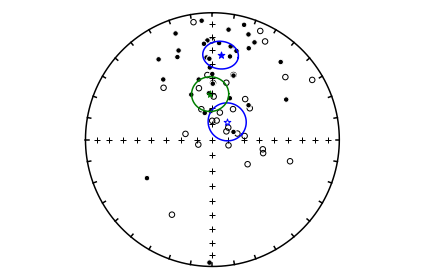

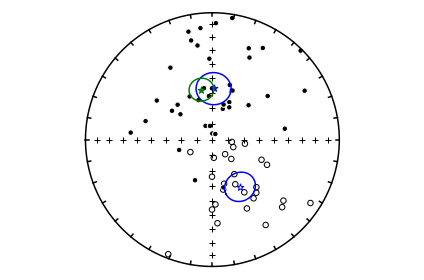

In [7]:
di_s =np.array([foldtestdata["Ds"], foldtestdata["Is"]]).transpose()
di_g =np.array([foldtestdata["Dg"], foldtestdata["Ig"]]).transpose()
means_g = fisher_means(di_g,1, tc = False)
means_s = fisher_means(di_s,2, tc = True)
means = pd.concat([means_g,means_s], axis =1).round(1)
means


### Save excel file

In [8]:
outputfile = "foldtestmeans.xlsx"
export_file = ''
print('save and overwrite', "foldtestmeans.xlsx?")
while export_file != "y" and export_file != "n":
    export_file = str(input("(y/n)?:"))
    if export_file == 'y':
        means.to_excel(outputfile)
        print("file saved to foldtestmeans.xlsx")
    else:
        pass

save and overwrite foldtestmeans.xlsx?
(y/n)?:n


### Fold test

In [9]:
help(ipmag.bootstrap_fold_test)

Help on function bootstrap_fold_test in module pmagpy.ipmag:

bootstrap_fold_test(Data, num_sims=1000, min_untilt=-10, max_untilt=120, bedding_error=0, save=False, save_folder='.', fmt='svg', ninety_nine=False)
    Conduct a bootstrap fold test (Tauxe and Watson, 1994)
    
    Three plots are generated: 1) equal area plot of uncorrected data;
    2) tilt-corrected equal area plot; 3) bootstrap results showing the trend
    of the largest eigenvalues for a selection of the pseudo-samples (red
    dashed lines), the cumulative distribution of the eigenvalue maximum (green
    line) and the confidence bounds that enclose 95% of the pseudo-sample
    maxima. If the confidence bounds enclose 100% unfolding, the data "pass"
    the fold test.
    
    Parameters
    ----------
    Data : a numpy array of directional data [dec, inc, dip_direction, dip]
    num_sims : number of bootstrap samples (default is 1000)
    min_untilt : minimum percent untilting applied to the data (default is -10%)

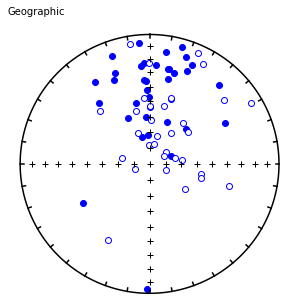

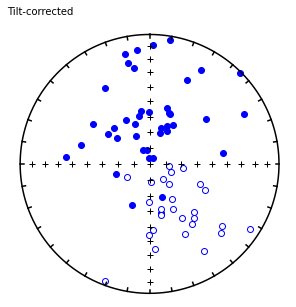

doing  1000  iterations...please be patient.....

tightest grouping of vectors obtained at (95% confidence bounds):
69 - 101 percent unfolding
range of all bootstrap samples: 
63  -  109 percent unfolding


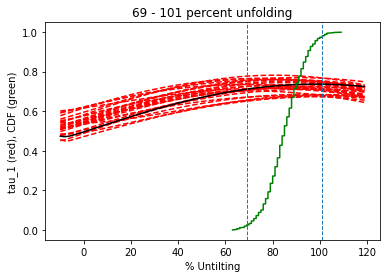

plot saved to bootstrap_CDF.pdf


In [10]:
ipmag.bootstrap_fold_test(data, save = True, fmt = 'pdf', num_sims=1000)
# saving plot to file
print('plot saved to bootstrap_CDF.pdf')
